In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/clean_theme.R")
library(tidyverse)
library(magrittr)
library(scales)
library(ggstars)

options("readr.num_columns" = 0)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

# read events
events <- lapply(c("A3", "A5", "AF", "AL", "MX", "RI", "SE"), function(eventType){
    read_tsv(paste0("../data/events/tcga_event_annotation_full_", eventType, ".ioe")) %>%
        # split the alternative and total columns into multiple rows
        mutate(alternative_transcripts = strsplit(alternative_transcripts, ",")) %>%
        unnest(alternative_transcripts) %>%
        mutate(total_transcripts = strsplit(total_transcripts, ",")) %>%
        unnest(total_transcripts) %>%
        select(alternative_transcripts,total_transcripts,event_id) %>%
        mutate(eventType = eventType)
}) %>% do.call("rbind",.)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



In [2]:
# skipping: events where normal has the event
nt <- merge(switches, events, 
      by.x=c("Normal_transcript","Tumor_transcript"), 
      by.y=c("alternative_transcripts", "total_transcripts")) %>%
    mutate(what = "skipping")

# inclusion: events where tumor has the event
tn <- merge(switches, events, 
      by.x=c("Tumor_transcript","Normal_transcript"), 
      by.y=c("alternative_transcripts", "total_transcripts")) %>%
    mutate(what = "inclusion")

# join
events_switches <- rbind(nt,tn) %>%
    select(Normal_transcript,Tumor_transcript,event_id,eventType,what) %>%
    # take only those where only either normal or tumor undergo the event
    group_by(Normal_transcript,Tumor_transcript,event_id) %>%
    filter(n() == 1)

In [3]:
# number of switches with differences in events
events_switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    unique %>%
    nrow

events_switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    nrow

[1] 5667

[1] 5667

In [4]:
# total number of switches
switches %>%
    select(Normal_transcript,Tumor_transcript) %>%
    unique %>%
    nrow

[1] 8122

Loading required package: RColorBrewer


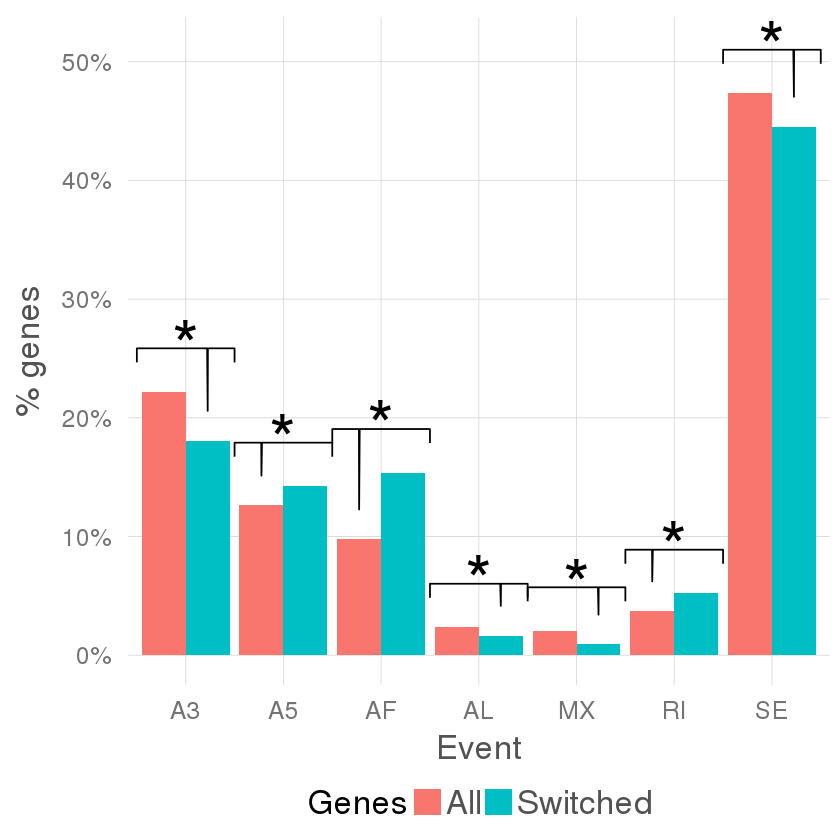

In [5]:
# compare proportions to background ie all events
events_switches.freq <- events_switches %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(., f = n()/nrow(.)) %>%
    mutate(Genes = "Switched")

events.freq <- events %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(., f = n()/nrow(.)) %>%
    mutate(Genes = "All")

# compare proportions to background ie all events
events_switches.n <- events_switches %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(f = n())

events.n <- events %>%
    select(eventType) %>%
    group_by(eventType) %>%
    summarise(f = n())

tests <- merge(events_switches.n, events.n, by="eventType", suffixes = c(".switches",".all")) %>%
    mutate(n.switches = sum(f.switches) - f.switches, 
           n.all = sum(f.all) - f.all)
p <- apply(tests %>% select(n.switches, f.switches, n.all, f.all), 1, function(x){
    fisher.test(matrix(x,2,2))$p.value
})

gg <- rbind(events_switches.freq, events.freq) %>%
    ggplot(aes(eventType, f, fill = Genes)) + 
        geom_bar(stat="identity", position="dodge") +
        labs(x = "Event", y = "% genes") +
        scale_y_continuous(labels = percent)  +
        clean_theme() +
        theme(legend.position="bottom")

star_bar(gg, p < 0.025, dist = 0.025)